# 실 습
- 딥러닝을 이용한 고객이탈예측

# 1. 라이브러리

In [66]:
# 데이터 처리 도구
import pandas as pd             # 데이터프레임
import numpy as np              # 수치 계산
import matplotlib.pyplot as plt # 시각화

# 딥러닝
import torch                    # 딥러닝
import torch.nn as nn           # 신경망
import torch.optim as optim     # 최적화

# 하이퍼파라미터 튜닝
import optuna

# 데이터 가공
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# 2. 데이터 불러오기

In [67]:
# 데이터 로드
file_path = './data/customer_churn_dataset.csv'
df = pd.read_csv(file_path)

df.head()

,customer_id,tenure,monthly_charges,total_charges,contract,payment_method,internet_service,tech_support,online_security,support_calls,churn
0,1,52,54.20,2818.40,Month-to-month,Credit,DSL,No,Yes,1,No
1,2,15,35.28,529.20,Month-to-month,Debit,DSL,No,No,2,No
2,3,72,78.24,5633.28,Month-to-month,Debit,DSL,No,No,0,No
3,4,61,80.24,4894.64,One year,Cash,Fiber,Yes,Yes,0,No
4,5,21,39.38,826.98,Month-to-month,UPI,Fiber,No,No,4,Yes


In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       20000 non-null  int64  
 1   tenure            20000 non-null  int64  
 2   monthly_charges   20000 non-null  float64
 3   total_charges     20000 non-null  float64
 4   contract          20000 non-null  object 
 5   payment_method    20000 non-null  object 
 6   internet_service  17987 non-null  object 
 7   tech_support      20000 non-null  object 
 8   online_security   20000 non-null  object 
 9   support_calls     20000 non-null  int64  
 10  churn             20000 non-null  object 
dtypes: float64(2), int64(3), object(6)
memory usage: 1.7+ MB


In [80]:
df.describe()

,customer_id,tenure,monthly_charges,total_charges,support_calls
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000
mean,10000.500000,36.467450,70.010531,2543.979209,1.51255
std,5773.647028,20.773984,28.890239,1882.949804,1.23524
min,1.000000,1.000000,20.000000,20.230000,0.00000
25%,5000.750000,18.000000,45.210000,1045.837500,1.00000
50%,10000.500000,36.000000,70.090000,2096.495000,1.00000
75%,15000.250000,54.000000,95.072500,3690.337500,2.00000
max,20000.000000,72.000000,120.000000,8629.920000,8.00000


In [70]:
df.isnull().sum()

customer_id            0
tenure                 0
monthly_charges        0
total_charges          0
contract               0
payment_method         0
internet_service    2013
tech_support           0
online_security        0
support_calls          0
churn                  0
dtype: int64

# 3. 데이터 전처리

In [71]:
# 1. 결측치 제거
data = df.dropna()

# 2. 문자 -> 숫자 변환 (인코딩) object -> int
columns_to_change = [
    'contract',
    'payment_method',
    'internet_service',
    'tech_support',
    'online_security',
    'churn'
]

# LabelEncoder로 object -> int 자동변환
le = LabelEncoder()
for col in columns_to_change:
    data[col] = le.fit_transform(data[col])

# 3. x, y 데이터 분리
X_data = data.drop('churn', axis=1).values # churn을 뺀 나머지
y_data = data['churn'].values              # 그냥 churn 그 자체

# 4. Train, Test 데이터 나누기
# 80%는 학습, 20%는 테스트
X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data,
    test_size=0.2,
    random_state=42
)

# 5. 스케일링 (모든 숫자를 평균 0, 분산 1로 맞춤)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 6. Tensor로 변환
# y(정답)은 0, 1등 숫자만 있으니까 2차원 텐서로 바꿔야함
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).reshape(-1, 1) # [N] -> [N, 1] 모양 맞추기
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test).reshape(-1, 1)

print(f"데이터 크기: {X_train_tensor.shape}")

데이터 크기: torch.Size([14389, 10])


# 4. 모델

In [72]:
# 모델 설계도 그리기
class MyModel(nn.Module):
    def __init__(self, input_dim, hidden_size):
        super(MyModel, self).__init__()
        # Layer
        self.layer1 = nn.Linear(input_dim, hidden_size) # 입력층 -> 은닉층1
        self.activation = nn.ReLU()                     # 활성화 함수
        self.layer2 = nn.Linear(hidden_size, 32)        # 은닉층1 -> 은닉층2
        self.layer3 = nn.Linear(32, 1)                  # 은닉층2 -> 출력층
        self.sigmoid = nn.Sigmoid()                     # 확률값으로 변경
        
    def forward(self, x):
        # 순전파
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.sigmoid(self.layer3(x))
        return x

print("모델 설계도가 준비되었습니다.")

모델 설계도가 준비되었습니다.


# 5. Optuna를 활용한 자동 튜닝
Optuna는 우리가 일일이 반복문을 돌리지 않아도, 자동으로 최적의 설정(Hyperparameter)을 찾아줍니다.
마치 '탐정'처럼 여러 실험을 해보고 가장 점수가 높은 곳을 찾아냅니다.

In [81]:
# 1. 실험 목표(Objective) 정의하기
def objective(trial):
    # Optuna
    # learning rate (0.0001 ~ 0.1 사이에서 적절한 값 추천)
    lr = trial.suggest_float("lr", 0.0001, 0.1, log=True) 
    
    # 은닉층 (32, 64, 128 중 하나 추천)
    hidden = trial.suggest_categorical("hidden_size", [32, 64, 128])
    
    # 모델 생성
    model = MyModel(input_dim=X_train_tensor.shape[1], hidden_size=hidden)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()
    
    # 100번만 공부시켜보고 성능 측정
    for epoch in range(100):
        model.train()
        optimizer.zero_grad()
        prediction = model(X_train_tensor)
        loss = criterion(prediction, y_train_tensor)
        loss.backward()
        optimizer.step()
        
    # 평가
    model.eval()
    with torch.no_grad():
        y_prob = model(X_test_tensor)
        y_pred = (y_prob >= 0.5).float()
        acc = accuracy_score(y_test, y_pred.numpy())
        
    return acc # 점수 반환

# 2. 옵튜나 학습 시작
study = optuna.create_study(direction="maximize") # 점수가 높을수록 좋음(maximize)
study.optimize(objective, n_trials=30) # 30번 시도해봐!

# 3. 결과 확인
print("\n 최적의 하이퍼 파라미터:")
best_params = study.best_params
print(f"학습률(lr): {best_params['lr']:.5f}")
print(f"은닉층 크기(hidden_size): {best_params['hidden_size']}")
print(f"최고 정확도: {study.best_value*100:.2f}%")

[I 2026-01-12 14:13:45,953] A new study created in memory with name: no-name-286dd0ef-cac7-4500-a1b6-32eab8fa629f
[I 2026-01-12 14:13:46,365] Trial 0 finished with value: 0.7301278488048916 and parameters: {'lr': 0.0005382648754509321, 'hidden_size': 32}. Best is trial 0 with value: 0.7301278488048916.
[I 2026-01-12 14:13:46,906] Trial 1 finished with value: 0.8321289605336298 and parameters: {'lr': 0.04066657211630909, 'hidden_size': 64}. Best is trial 1 with value: 0.8321289605336298.
[I 2026-01-12 14:13:47,453] Trial 2 finished with value: 0.7762645914396887 and parameters: {'lr': 0.0007626717277295812, 'hidden_size': 64}. Best is trial 1 with value: 0.8321289605336298.
[I 2026-01-12 14:13:47,868] Trial 3 finished with value: 0.8324068927181768 and parameters: {'lr': 0.01547160026707746, 'hidden_size': 32}. Best is trial 3 with value: 0.8324068927181768.
[I 2026-01-12 14:13:48,284] Trial 4 finished with value: 0.8415786548082268 and parameters: {'lr': 0.021175126989471448, 'hidden_s


 최적의 하이퍼 파라미터:
학습률(lr): 0.06300
은닉층 크기(hidden_size): 32
최고 정확도: 84.57%


# 6. optuna가 찾아준걸로 모델 학습

In [82]:
# 최고의 설정 가져오기
final_lr = best_params['lr']
final_hidden = best_params['hidden_size']

# 모델 다시 만들기
model = MyModel(
    input_dim = X_train_tensor.shape[1],
    hidden_size=final_hidden
)
optimizer = optim.Adam(
    model.parameters(),
    lr = final_lr
)
criterion = nn.BCELoss()

epochs = 100
losses = []

print(f"lr={final_lr:.5f} \nhidden={final_hidden}")

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    prediction = model(X_train_tensor)
    loss = criterion(prediction, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    if (epoch + 1) % 50 == 0:
        print(f"{epoch+1}번 완료ㅋㅋ Loss: {loss.item():.2f}")

print("끝났다")

lr=0.06300 
hidden=32
50번 완료ㅋㅋ Loss: 0.45
100번 완료ㅋㅋ Loss: 0.43
끝났다


# 7. 최종 결과 확인

accuracy: 84.02%


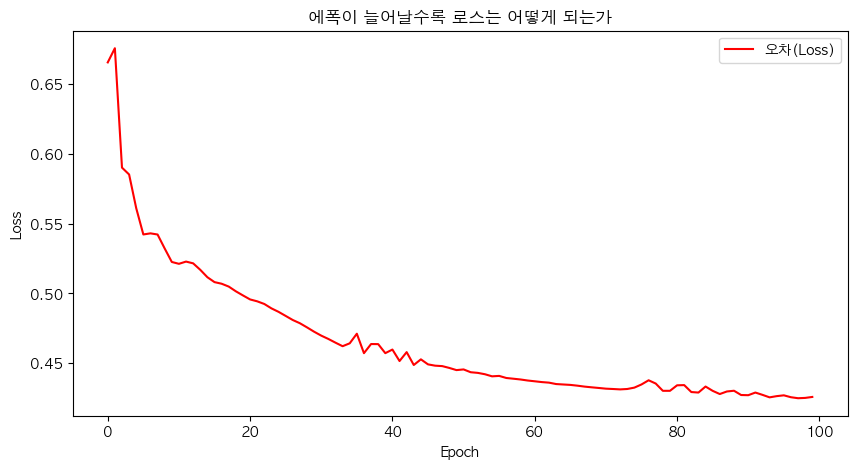

In [84]:
# 1. 평가
model.eval()
with torch.no_grad():
    y_prob = model(X_test_tensor)
    y_pred = (y_prob >= 0.5).float()
    acc = accuracy_score(y_test, y_pred.numpy())

print(f"accuracy: {acc*100:.2f}%")

# 2. 그래프
plt.figure(figsize=(10, 5))
plt.plot(losses, label='오차(Loss)', color='red')
plt.title('에폭이 늘어날수록 로스는 어떻게 되는가')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()